In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt
import keras

keras.__version__

Using TensorFlow backend.
paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/royalshoulders/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'2.2.4'

In [2]:
df = pd.read_csv('cleaned_dataset.csv')

In [25]:
df['rating_class'] = df['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)
X = df['clean_text']
Y = df['rating_class']

In [4]:
df['clean_text'][:4]

0    choose one product take care face rest life wo...
1    make skin lovely smooth woman near need help g...
2    work well reasonable price use regenerating se...
3    work lady try many product totally disappointe...
Name: clean_text, dtype: object

In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [6]:
normed_corpus = normalize_corpus(X)

# Build Corpus Vocabulary

word_index is a dictionary mapping words to an integer index.

In [7]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(normed_corpus)
word2id = tokenizer.word_index

Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors

In [8]:
# The PAD term is typically 
# used to pad context words to a fixed length if needed.
# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()} # reverse word indexam
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in normed_corpus]

In [9]:
list(id2word.items())[:10]

[(1, 'hair'),
 (2, 'use'),
 (3, 'product'),
 (4, 'skin'),
 (5, 'like'),
 (6, 'good'),
 (7, 'feel'),
 (8, 'great'),
 (9, 'get'),
 (10, 'work')]

In [10]:
vocab_size = len(word2id)
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])
print('='*90,'\n Word Indices of words in First Doc: \n', wids[0])

Vocabulary Size: 25017
Vocabulary Sample: [('hair', 1), ('use', 2), ('product', 3), ('skin', 4), ('like', 5), ('good', 6), ('feel', 7), ('great', 8), ('get', 9), ('work', 10)]
 Word Indices of words in First Doc: 
 [686, 16, 3, 63, 117, 22, 622, 512, 15, 74, 7353, 74, 543, 4, 108, 1119, 4, 948, 708, 36, 10, 29, 6, 74, 594, 2798, 74, 80, 116, 211, 128, 68, 878, 544, 2, 4, 328, 98, 41, 522, 28, 20, 291, 3208, 860, 33, 32, 118, 87, 161, 74, 144, 81, 460, 4, 10, 19, 322, 9, 95, 851, 208, 131, 4, 2, 74, 6407, 988, 6408, 410, 16, 214, 884, 6, 16, 16, 341, 171, 2517, 6, 223, 233, 162, 3, 43, 2496, 1763, 8, 1119, 40, 686, 16, 22, 75, 622, 512, 15, 1021]


# Robust Word2Vec Models with Gensim 

In [19]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in normed_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10   # Context window size                                                                                    
min_word_count = 10    # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)



In [20]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['hair', 'use', 'feel', 'skin', 'good', 'like', 'get','product']}
similar_words

{'hair': ['conditioner', 'frizzy', 'blow', 'style', 'straight'],
 'use': ['skip', 'apply', 'two', 'twice', 'try'],
 'feel': ['feeling', 'afterwards', 'leave', 'soft', 'really'],
 'skin': ['face', 'complexion', 'breakout', 'moisturizer', 'redness'],
 'good': ['great', 'decent', 'nice', 'like', 'excellent'],
 'like': ['nice', 'kind', 'good', 'dislike', 'strange'],
 'get': ['put', 'toss', 'grab', 'done', 'cowlick'],
 'product': ['products', 'brand', 'adovia', 'impress', 'offering']}

Let’s also visualize the words of interest and their similar words using their embedding vectors after reducing their dimensions to a 2-D space with t-SNE

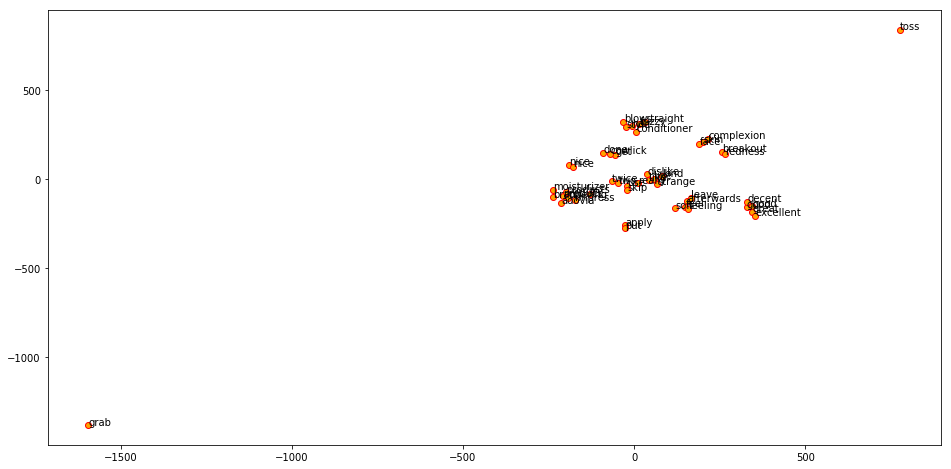

In [21]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

Now what is a word embedding in this scenario? It’s typically a dense vector for each word as depicted in the following example for the word 'product'

In [14]:
w2v_model.wv['product']

array([-0.38544682, -0.73007405, -0.6454506 , -0.48161015, -0.1587838 ,
       -1.3831708 , -1.3946549 ,  0.8384353 , -0.45098132, -1.1476029 ,
       -0.19808137, -1.0709006 , -0.9375472 , -0.68379486,  0.24754241,
       -0.06268775,  0.04755555, -0.17580779,  0.41752806, -0.34474286,
       -0.08972563, -0.17264646, -0.75037205, -0.69091254,  1.3072566 ,
       -1.1637266 ,  0.928778  ,  1.2724602 , -1.2215451 ,  0.04343694,
        1.6474293 ,  1.4069269 , -0.42193916, -0.18003483, -1.2132025 ,
       -0.15296501,  0.3836316 , -0.34004417,  1.1044201 ,  0.47812718,
        0.65977085,  0.04233569, -0.88287836,  0.12468629,  0.67487025,
       -0.14562126, -0.7462282 ,  0.28591397, -0.2007338 ,  0.04338367,
       -0.4037941 , -0.40295994, -0.7287373 ,  0.4031838 , -0.27770534,
       -0.5872059 ,  0.2402255 , -0.91284716, -0.5341864 , -1.4475493 ,
       -0.33889064, -0.92574686, -0.57535595, -1.0987998 , -1.1589563 ,
       -0.15191282, -0.79448843, -0.636146  , -0.3820854 , -0.14

In [22]:
# save and reload the model
w2v_model.save('w2v_model')
w2v_m = gensim.models.Word2Vec.load('w2v_model')

# KERAS with Pre-Trained Embedding

Now I will show how you can use pre-trained gensim embedding layers in our Keras models.

In [26]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

#Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 100

training_samples = 16000
test_samples = 8509
data = pad_sequences(wids, maxlen=maxlen)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = Y[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + test_samples]
y_test = labels[training_samples: training_samples + test_samples]








In [27]:
print('Found %s unique tokens.' % len(word2id))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 25017 unique tokens.
Shape of data tensor: (24509, 100)
Shape of label tensor: (24509,)


Create an appropriately sized numpy array then loop through each word in the vocabulary. While looping grab the word vector associated with that word by using the wv index from *word_index* dictionary and add the word vector into our numpy array

In [74]:
# Convert the wv vectors into a numpy matrix that is suitable for Keras or TF
# feature_size=100
max_words = 5000

embedding_matrix = np.zeros((max_words, feature_size))
for i in range(len(w2v_m.wv.vocab)):
    embedding_vector = w2v_m.wv[w2v_m.wv.index2word[i]]
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector


In [75]:
embedding_matrix

array([[-0.30776748, -0.02978337,  2.9478085 , ..., -0.90565509,
        -2.03580022, -2.66564655],
       [-0.16426596,  0.46376428, -0.77661151, ...,  0.59790379,
         0.27612627, -3.0169301 ],
       [-1.30516934, -0.54560524,  0.0269276 , ...,  2.04839587,
         1.12006497,  0.49025628],
       ...,
       [ 0.10372929,  1.20700169, -0.19384222, ...,  0.32444376,
        -0.59062737,  0.95990175],
       [-0.51854295,  0.5767166 , -0.18398468, ..., -1.25318134,
         0.47744939,  0.35407564],
       [ 1.2466737 ,  0.35314795, -0.50095963, ..., -0.13063075,
        -0.90473646, -0.24260105]])

In [76]:
embedding_matrix.shape

(5000, 100)

In [77]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, feature_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 820,065
Trainable params: 820,065
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


# Train and Evaluate

In [79]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.3)
model.save_weights('pre_trained_w2v_model.h5')

Train on 11200 samples, validate on 4800 samples
Epoch 1/10


InvalidArgumentError: indices[30,5] = 6766 is not in [0, 5000)
	 [[{{node embedding_9/embedding_lookup}}]]

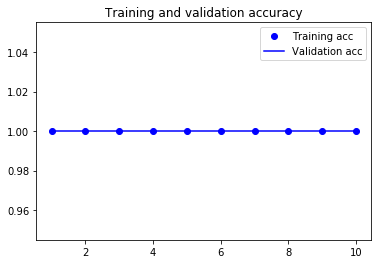

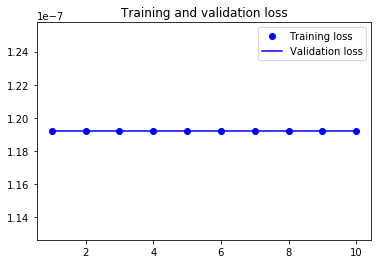

In [80]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [73]:
model.load_weights('pre_trained_w2v_model.h5')
model.evaluate(x_test, y_test)

8509/8509 [==============================] - 0s 19us/step


[0.0003425106541348998, 0.9998824773768951]

CHECKED with this 

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb